# Simultaneous vs Separate vs White_Light Fitting

With `chromatic_fitting` there are 3 different types of fit available: **Simultaneous**, **Separate** and **White_Light**. Respectively, they mean fitting all wavelengths simultaneously (possibility for shared parameters), fitting each wavelength independantly (no shared parameters) and averaging over all wavelengths to generate a white-light curve and fitting that. In this tutorial we will demonstrate all three methods and see the differences between them. `chromatic_fitting` is designed so that the interface should be the same regardless of the method chosen!

We will return to the transit model tutorial (in a speedy way, so if you haven't already done this tutorial or are unfamiliar with `chromatic_fitting` I recommend going through this now):

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
numpy v1.21.5
chromatic v0.3.14
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

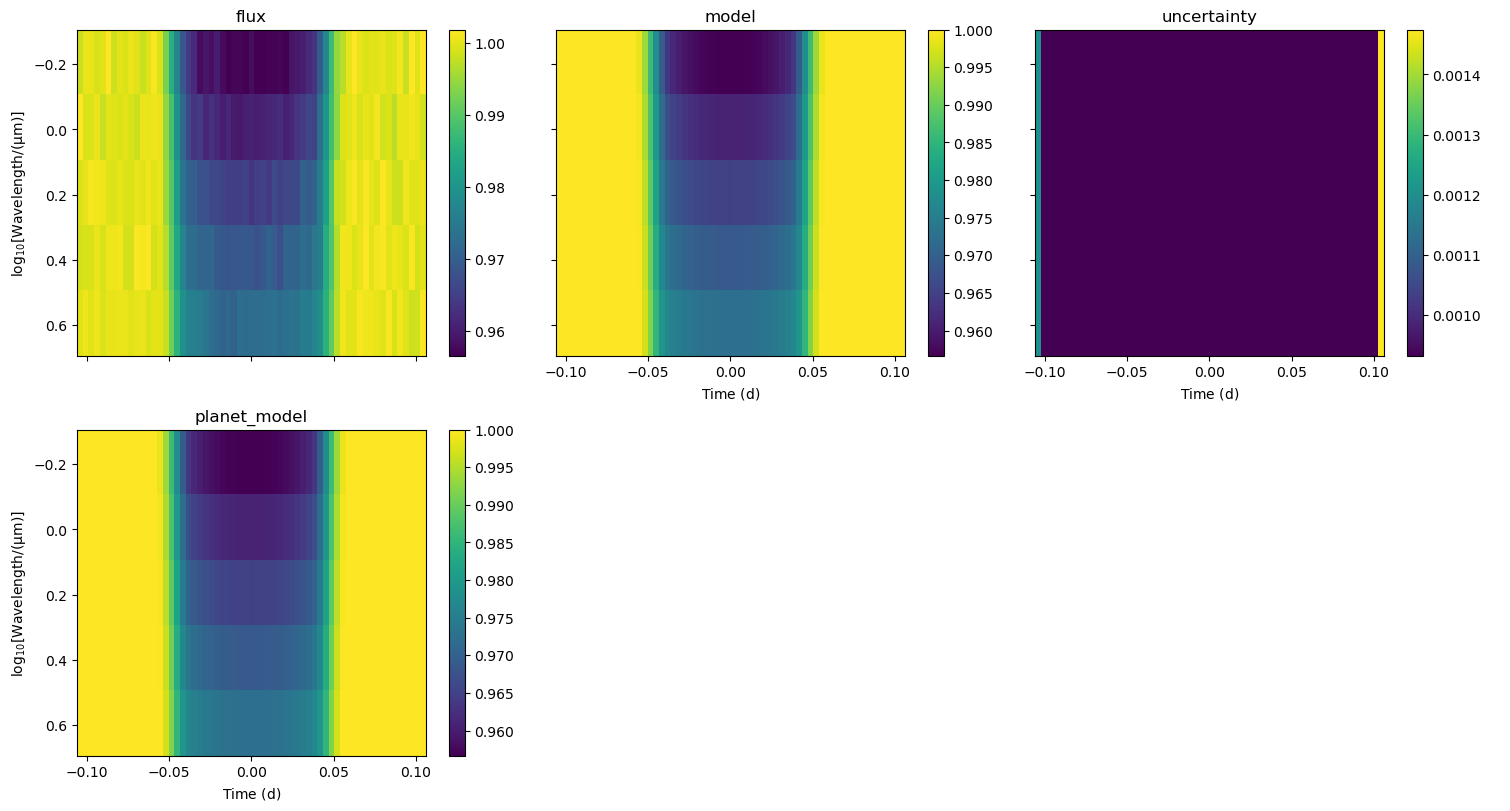

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin into 5 wavelength bins:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

# show the simulated dataset
rbin5.imshow_quantities();

In [3]:
# create transit model:
t = TransitModel()

# add our parameters:
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.05,0.35], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 1.5707963267948966 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.05, 0.35], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



In [4]:
# attach the Rainbow object to the model:
t.attach_data(rbin5)

Now this is where we have to make the decision of which optimization method to use. By default the optimization is simultaneous:

In [5]:
t.optimization

'simultaneous'

## Separate

However, we can change this to one of the other two if we like

In [6]:
t.choose_optimization_method("separate")
t.optimization

'separate'

The optimization method (if you want to change it) needs to be defined before we call `.setup_lightcurves()`.

In [7]:
# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

  0%|          | 0/1 [00:00<?, ?it/s]

If we look at our `PyMC3` model, if we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a PyMC3 model with only 'Wavelike' parameters (one value for each wavelength).

In [8]:
t._pymc3_model

In [9]:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 WavelikeFitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius', shape=(5, 1)) for each wavelength 🧮>

transit_stellar_mass =
  <🧮 WavelikeFitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass', shape=(5, 1)) for each wavelength 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='transit_radius_ratio', shape=(5, 1)) for each wavelength 🧮>

transit_period =
  <🧮 WavelikeFixed | one value for each wavelength (5 elements)🧮>

transit_epoch =
  <🧮 WavelikeFitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch', shape=(5, 1)) for each wavelength 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline', shape=(5, 1)) for each wavelength 🧮>

transit_impact_parameter =
  <🧮 WavelikeFitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter', shape=(5, 1)) for each wavelength 🧮>

transit_eccentricity =
  <🧮 WavelikeFixed | one value for

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


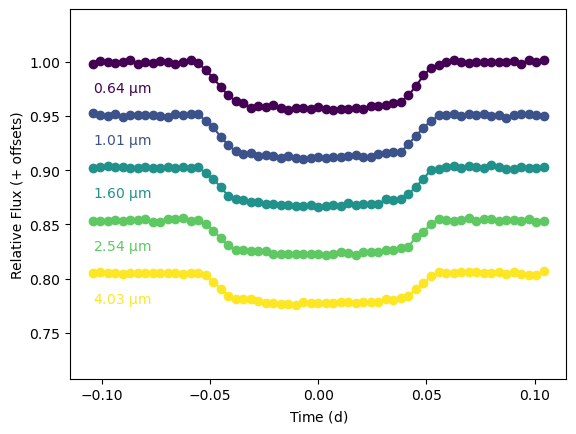

In [10]:
t.plot_lightcurves();

## White_Light

Now we can change to another type of optimization method. **BEWARE!** In changing to the *separate* optimization method we have changed our parameters to all be "WavelikeFitted" or "WavelikeFixed" therefore they won't have memory of their parameter class (Fitted or Fixed) before this! Therefore, it is crucial to `.reinitialize()` after using the *separate* optimization, before we try and rerun the fitting!

In [11]:
# If we want to change the optimization method then we need to reinitialize all the models/priors!
t.reinitialize()

Cleared transit_radius_ratio prior
Cleared transit_baseline prior
Cleared transit_limb_darkening prior


In [12]:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='transit_radius_ratio', shape=(5, 1)) for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline', shape=(5, 1)) for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 1.5707963267948966 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.05, 0.35], shape=(5, 2), name='transit_limb_darkening') for each wavelength 🧮>



In [13]:
# change the optimization method to white_light:
t.choose_optimization_method("white_light")

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Now let's have another look at our PyMC3 model:

In [14]:
t._pymc3_model

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


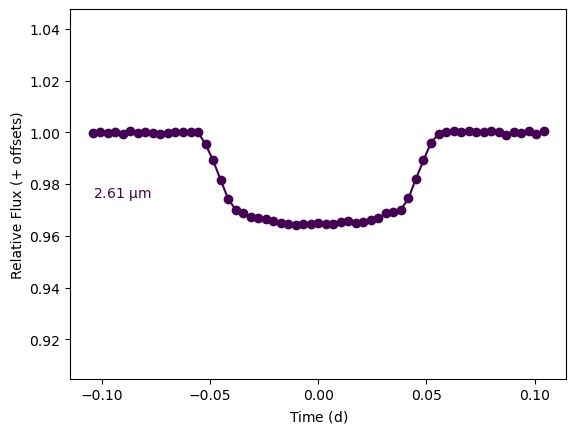

In [15]:
t.plot_lightcurves();

We should only have one wavelength - a white-lightcurve that we can access using `.white_light`:

In [16]:
t.white_light

<Simulated🌈(1w, 61t)>